# Лабораторная работа 3

Датасет - **Цены на кофе**	https://www.kaggle.com/datasets/mayankanand2701/starbucks-stock-price-dataset


**Бизнес-цели**: 
1. Прогнозирование цены закрытия акции для поддержки принятия решений по инвестициям.
2. Оценка волатильности акций Starbucks для долгосрочных стратегий инвестирования.

**Цели технического проекта**: 
1. Создание модели машинного обучения для прогнозирования цены закрытия акций на основе исторических данных (дат, цен открытия, максимальных и минимальных цен, объёма торгов).
2. Разработка системы, которая вычисляет и анализирует волатильность на основе исторической ценовой информации и объёмов торгов.

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv("data/Coffe.csv")
print(df)

df['Date'] = pd.to_datetime(df['Date'])
df['Date_numeric'] = (df['Date'] - pd.Timestamp('1970-01-01')).dt.days
print(df['Date_numeric'])

            Date       Open       High        Low      Close  Adj Close  \
0     1992-06-26   0.328125   0.347656   0.320313   0.335938   0.260703   
1     1992-06-29   0.339844   0.367188   0.332031   0.359375   0.278891   
2     1992-06-30   0.367188   0.371094   0.343750   0.347656   0.269797   
3     1992-07-01   0.351563   0.359375   0.339844   0.355469   0.275860   
4     1992-07-02   0.359375   0.359375   0.347656   0.355469   0.275860   
...          ...        ...        ...        ...        ...        ...   
8031  2024-05-17  75.269997  78.000000  74.919998  77.849998  77.849998   
8032  2024-05-20  77.680000  78.320000  76.709999  77.540001  77.540001   
8033  2024-05-21  77.559998  78.220001  77.500000  77.720001  77.720001   
8034  2024-05-22  77.699997  81.019997  77.440002  80.720001  80.720001   
8035  2024-05-23  80.099998  80.699997  79.169998  79.260002  79.260002   

         Volume  
0     224358400  
1      58732800  
2      34777600  
3      18316800  
4      13

In [4]:
def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input 
    y = df_input[
        [stratify_colname]
    ]  

    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

bins = [df['Close'].min(), df['Close'].quantile(0.33), df['Close'].quantile(0.66), df['Close'].max()]
labels = ['Low', 'Medium', 'High']
df['Close_binned'] = pd.cut(df['Close'], bins=bins, labels=labels)
df = df.dropna()
# Now stratify using the binned values
df_train, df_val, df_test = split_stratified_into_train_val_test(
    df, stratify_colname="Close_binned", frac_train=0.60, frac_val=0.20, frac_test=0.20
)

print(df_train.columns) 
   
print("Обучающая выборка: ", df_train.shape)
print(df_train.Close.value_counts()) 

print("Контрольная выборка: ", df_val.shape)
print(df_val.Close.value_counts())

print("Тестовая выборка: ", df_test.shape)
print(df_test.Close.value_counts())

print("Обучающая выборка: ", df_train.shape)
print(df_train['Close_binned'].value_counts())

print("Контрольная выборка: ", df_val.shape)
print(df_val['Close_binned'].value_counts())

print("Тестовая выборка: ", df_test.shape)
print(df_test['Close_binned'].value_counts())


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Date_numeric', 'Close_binned'],
      dtype='object')
Обучающая выборка:  (4821, 9)
Close
0.750000      17
0.765625      15
0.882813      11
0.753906       9
0.773438       9
              ..
7.760000       1
88.459999      1
104.330002     1
10.850000      1
100.930000     1
Name: count, Length: 3690, dtype: int64
Контрольная выборка:  (1607, 9)
Close
0.835938      6
0.781250      5
0.757813      5
1.851563      4
0.738281      4
             ..
100.620003    1
6.020000      1
85.959999     1
91.529999     1
111.000000    1
Name: count, Length: 1436, dtype: int64
Тестовая выборка:  (1607, 9)
Close
0.703125     6
0.851563     6
0.750000     6
0.742188     5
0.781250     5
            ..
47.275002    1
31.760000    1
75.500000    1
2.406250     1
8.107500     1
Name: count, Length: 1427, dtype: int64
Обучающая выборка:  (4821, 9)
Close_binned
High      1639
Low       1591
Medium    1591
Name: count, dtype: int

In [5]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df_train, df_train["Close_binned"])
df_train_rus = pd.DataFrame(X_resampled)
print("Обучающая выборка после undersampling: ", df_train_rus.shape)
print(df_train_rus.Close.value_counts())

Обучающая выборка после undersampling:  (4773, 9)
Close
0.750000     17
0.765625     15
0.882813     11
0.773438      9
0.753906      9
             ..
58.810001     1
40.535000     1
91.860001     1
90.779999     1
96.970001     1
Name: count, Length: 3651, dtype: int64


In [6]:
df_train = pd.get_dummies(df_train, columns=['Close_binned'])
df_train['Volume_binned'] = pd.qcut(df_train['Volume'], q=4, labels=False)
df_train['Price_change'] = df_train['Close'] - df_train['Open']
print(df_train) 

           Date        Open        High         Low       Close  Adj Close  \
75   1992-10-13    0.464844    0.472656    0.457031    0.472656   0.366803   
7819 2023-07-17  100.830002  101.809998  100.040001  100.930000  98.501541   
6447 2018-01-31   57.230000   57.450001   56.700001   56.810001  49.579262   
706  1995-04-12    0.769531    0.789063    0.769531    0.785156   0.609317   
4437 2010-02-05   10.895000   11.020000   10.630000   10.850000   8.420099   
...         ...         ...         ...         ...         ...        ...   
4113 2008-10-22    5.120000    5.245000    4.880000    4.995000   3.876349   
4544 2010-07-12   12.635000   12.760000   12.490000   12.635000   9.845955   
6517 2018-05-11   57.720001   57.860001   57.070000   57.270000  50.514595   
3336 2005-09-21   11.642500   11.775000   11.530000   11.667500   9.054512   
3122 2004-11-15   13.797500   13.860000   13.687500   13.790000  10.701671   

        Volume  Date_numeric  Close_binned_Low  Close_binned_Me

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train[['Open', 'Close', 'High', 'Low', 'Volume']] = scaler.fit_transform(
    df_train[['Open', 'Close', 'High', 'Low', 'Volume']])
df_train['Volatility'] = df_train['High'] - df_train['Low']
print(df_train) 

           Date      Open      High       Low     Close  Adj Close    Volume  \
75   1992-10-13 -0.881061 -0.882121 -0.880250 -0.881109   0.366803 -0.731159   
7819 2023-07-17  2.093371  2.095750  2.098759  2.096893  98.501541 -0.670368   
6447 2018-01-31  0.801237  0.792199  0.802249  0.788980  49.579262 -0.109940   
706  1995-04-12 -0.872031 -0.872824 -0.870902 -0.871845   0.609317 -0.310940   
4437 2010-02-05 -0.571952 -0.572180 -0.575927 -0.573479   8.420099  0.527179   
...         ...       ...       ...       ...       ...        ...       ...   
4113 2008-10-22 -0.743100 -0.741883 -0.747938 -0.747047   3.876349  1.068937   
4544 2010-07-12 -0.520385 -0.521049 -0.520286 -0.520563   9.845955 -0.125044   
6517 2018-05-11  0.815758  0.804247  0.813318  0.802616  50.514595 -0.627741   
3336 2005-09-21 -0.549799 -0.549994 -0.549004 -0.549244   9.054512  0.109935   
3122 2004-11-15 -0.485933 -0.488725 -0.484463 -0.486324  10.701671 -0.282042   

      Date_numeric  Close_binned_Low  C

In [8]:
import featuretools as ft

es = ft.EntitySet(id="stocks")
es = es.add_dataframe(
    dataframe_name="stock_data", 
    dataframe=df_train,                            
    index="Date")

feature_matrix, feature_defs = ft.dfs(
    entityset=es, 
    target_dataframe_name="stock_data")

feature_defs

c:\Python312\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


[<Feature: Open>,
 <Feature: High>,
 <Feature: Low>,
 <Feature: Close>,
 <Feature: Adj Close>,
 <Feature: Volume>,
 <Feature: Date_numeric>,
 <Feature: Close_binned_Low>,
 <Feature: Close_binned_Medium>,
 <Feature: Close_binned_High>,
 <Feature: Volume_binned>,
 <Feature: Price_change>,
 <Feature: Volatility>,
 <Feature: DAY(Date)>,
 <Feature: MONTH(Date)>,
 <Feature: WEEKDAY(Date)>,
 <Feature: YEAR(Date)>]

In [9]:
# Оценка предсказательной способности
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
df_train_regression = df_train.copy()

X_train = df_train_regression.drop(['Close', 'Date'], axis=1)
y_train = df_train_regression['Close']
X_test = df_test.drop(['Close', 'Date'], axis=1)
y_test = df_test['Close']

X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print(X_train_encoded.dtypes)

Open                   float64
High                   float64
Low                    float64
Adj Close              float64
Volume                 float64
Date_numeric             int64
Close_binned_Low          bool
Close_binned_Medium       bool
Close_binned_High         bool
Volume_binned            int64
Price_change           float64
Volatility             float64
dtype: object


In [10]:
model = LinearRegression()
model.fit(X_train_encoded, y_train)

predictions = model.predict(X_test_encoded)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print("Средняя абсолютная ошибка:", mae)
print("Среднеквадратичная ошибка:", mse)

Средняя абсолютная ошибка: 0.28573230577357767
Среднеквадратичная ошибка: 0.2813734754209575


In [11]:
# Оценка скорости вычисления
import time
start_time = time.time()
model.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

start_time = time.time()
predictions = model.predict(X_test_encoded)
prediction_time = time.time() - start_time

print(f'время, затраченное на обучение модели: {training_time}. Время, затраченное на предсказание: {prediction_time}')

время, затраченное на обучение модели: 0.025032997131347656. Время, затраченное на предсказание: 0.0


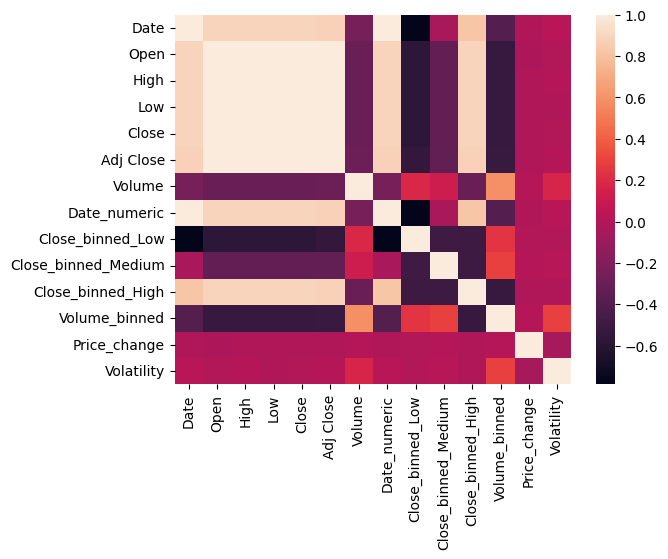

In [12]:
# Оценка корреляции
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_train_regression.corr()
sns.heatmap(corr_matrix, annot=False)
plt.show()